In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
import os
import sys
import glob
import pickle
import time
import random
import itertools
import networkx as nx
from pathlib import Path
from scipy.optimize import curve_fit, minimize
from scipy.stats import entropy
from sklearn.metrics import r2_score
from matplotlib.patches import Wedge
from pprint import pprint
import importlib.util

In [2]:
base_path = '/content/drive/MyDrive/SYNC_Projects/IS'

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:

eps=1e-9 #Conjugation rate

# Define relative paths from the base path
pathPARAMS = os.path.join(base_path, 'data/')
pathFIGURES = os.path.join(base_path, 'figures/')
pathCODE = os.path.join(base_path, 'code/')
pathSIM = os.path.join(base_path, 'runs_eps%s/'%eps)

# Verify paths and imported data
print("pathDATA:", pathPARAMS)
print("pathFIGURES:", pathFIGURES)
print("pathCODE:", pathCODE)
print("pathSIM:", pathSIM)

module_path = os.path.join(pathCODE, "MonodGillespieIS_multispecies.py")

# Load the module dynamically
spec = importlib.util.spec_from_file_location("mg", module_path)
mg = importlib.util.module_from_spec(spec)

spec.loader.exec_module(mg)

print("Module loaded successfully!")

pathDATA: /content/drive/MyDrive/SYNC_Projects/IS/data/
pathFIGURES: /content/drive/MyDrive/SYNC_Projects/IS/figures/
pathCODE: /content/drive/MyDrive/SYNC_Projects/IS/code/
pathSIM: /content/drive/MyDrive/SYNC_Projects/IS/runs_eps1e-09/
Module loaded successfully!


## Simulation parameters

In [4]:

# Define parameters for each mutation-transposition level
num_mutationsSNP = 3  # Number of mutation levels
num_mutationsIS = 3  # Number of transposition levels

# Set experimental parameters
initial_resource = 1.0
simulation_time = 24.0
B0=1e8
num_days = 60
dilution_factor = 0.1  # dilution factor applied each day

num_reps = 3
days=range(0, num_days + 1)
strainIDs = ["K253", "K168", "K037", "K241", "K209"]  # Species IDs
species_colors=['orange','blue', 'purple', 'green',  'yellow']
strain_color_map = {strain: species_colors[i] for i, strain in enumerate(strainIDs)}


### Load parameters from file

Plasmid-free parameters for strain K253 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K253_0.pkl

Plasmid-bearing parameters for strain K253 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K253_p.pkl

Plasmid-free parameters for strain K168 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K168_0.pkl

Plasmid-bearing parameters for strain K168 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K168_p.pkl

Plasmid-free parameters for strain K037 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K037_0.pkl

Plasmid-bearing parameters for strain K037 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K037_p.pkl

Plasmid-free parameters for strain K241 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K241_0.pkl

Plasmid-bearing parameters for strain K241 loaded successfully from:
/content/dri

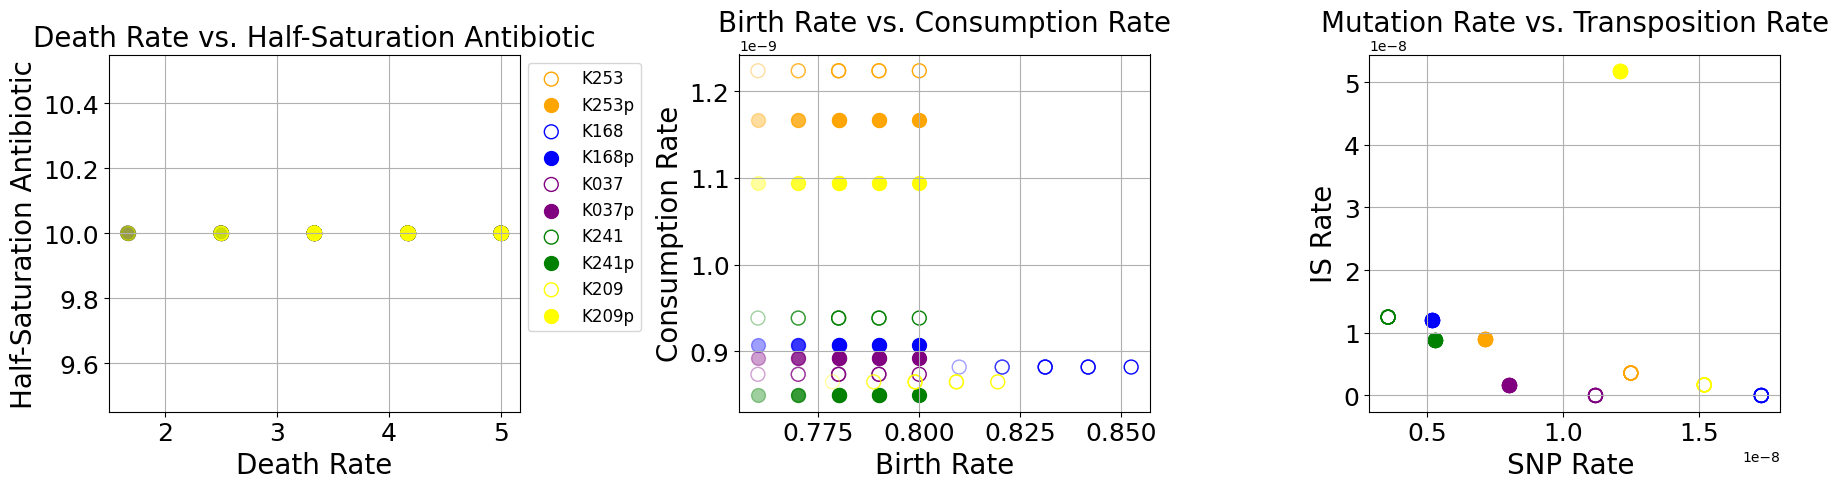

In [5]:

num_species = len(strainIDs)  # Number of species (e.g., "E" and "K")
strains_species = mg.load_strain_parameters(strainIDs, pathPARAMS)


# Example: Print strains_species to confirm
print("Strains for all species:")
for species_idx, strains in strains_species.items():
    print(f"Species {species_idx}:")
    print(f"  Plasmid-free strains: {strains['0']}")
    print(f"  Plasmid-bearing strains: {strains['p']}")


mg.plot_parameter_scatter(strainIDs, strains_species, strain_color_map)

### Define transmission network

In [6]:
# Define the plasmid transmission matrix
plasmid_matrix = np.array([
    [eps, eps, eps, eps, eps],  # K253
    [eps, eps, eps, eps, eps],  # K168
    [eps, eps, eps, eps, eps],   # K037
    [eps, eps, eps, eps, eps],   # K241
    [eps, eps, eps, eps, eps],   # K209
])

# Convert to Pandas DataFrame for better visualization
df_plasmid = pd.DataFrame(plasmid_matrix, index=strainIDs, columns=strainIDs)

# Display the matrix
print(df_plasmid)

              K253          K168          K037          K241          K209
K253  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K168  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K037  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K241  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K209  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09


## Run single-day clonal experiments




Running simulation for strain: K253

Running simulation for strain: K168

Running simulation for strain: K037

Running simulation for strain: K241

Running simulation for strain: K209


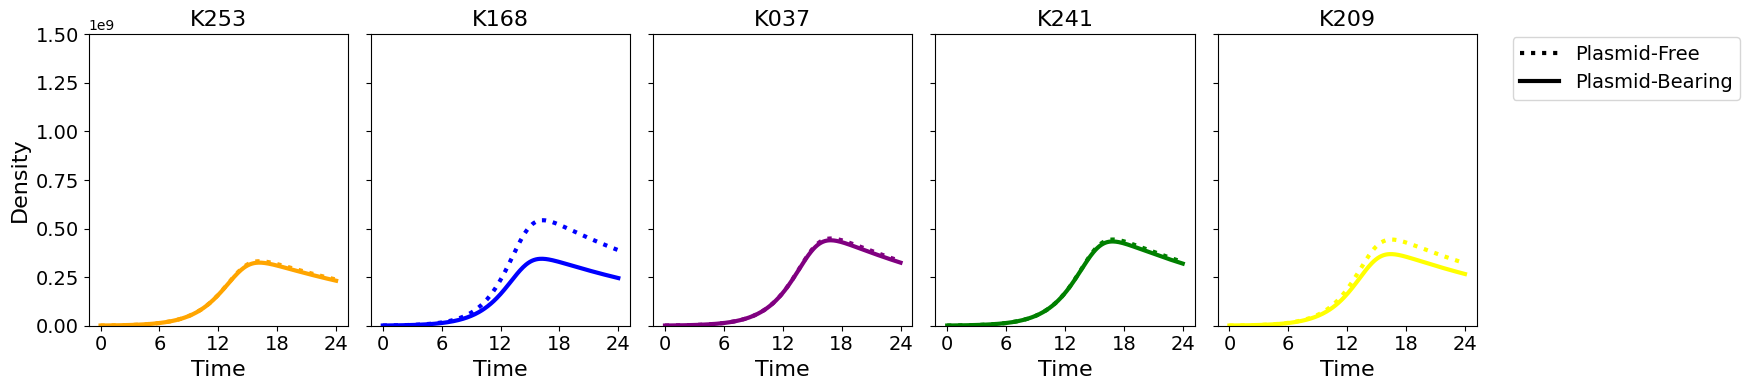

In [7]:

plasmid_matrix0 = np.array([
    [0, 0, 0, 0, 0],  # K253
    [0, 0, 0, 0, 0],  # K168
    [0, 0, 0, 0, 0],   # K037
    [0, 0, 0, 0, 0],   # K241
    [0, 0, 0, 0, 0],   # K209
])

antibiotic_concentration = 0.1
expe_label='A=%s'%antibiotic_concentration


# Store all results in a list
all_time_series_results = []

# Iterate over each strain and simulate it in isolation
for strain in strainIDs:
    print(f"\nRunning simulation for strain: {strain}")

    # Define initial conditions (only one strain starts with a population)
    initial_values_by_strain = {s: {"0": 0, "p": 0} for s in strainIDs}
    initial_values_by_strain[strain]["0"] = 1e6  # Start with 1e6 cells for plasmid-free
    initial_values_by_strain[strain]["p"] = 1e6  # Start with 1e6 cells for plasmid-bearing

    # Initialize populations
    populations_0, populations_p = mg.initialize_populations(
        num_species=num_species,
        num_mutationsSNP=num_mutationsSNP,
        num_mutationsIS=num_mutationsIS,
        strainIDs=strainIDs,
        initial_values_by_strain=initial_values_by_strain
    )

    # Run single-strain simulation (time-dependent)
    this_results = mg.runSimulationIS_multi_species(
        strains=strains_species,
        plasmid_matrix=plasmid_matrix0,
        initial_populations_0=populations_0,
        initial_populations_p=populations_p,
        num_days=1,
        antibiotic_concentration=antibiotic_concentration,
        initial_resource=initial_resource,
        simulation_time=simulation_time
    )

    # Append results, storing full time-dependent data
    all_time_series_results.append({
        "strain": strain,
        "results": this_results  # Includes time_points & population_values
    })



# Plot time vs density
mg.plotTimeDependentStrainDensities(
    results_list=all_time_series_results,  # List of results, one dictionary per strain
    num_species=num_species,
    species_colors=species_colors,
    species_labels=strainIDs,
    simulation_time=simulation_time,
    title='Time-Dependent Growth in Isolation',
    outPath=''
)

## Run single-day clonal dose-responses


In [8]:
# ------------------------------------------------------------------
# 1) Define antibiotic concentrations
antibiotic_concentrations = np.logspace(-3, 1, num=10)

# 2) Prepare output structure
dose_response_results = {strain: [] for strain in strainIDs}

# ------------------------------------------------------------------
for strain in strainIDs:
    print(f"\nRunning dose-response for strain: {strain}")

    for conc in antibiotic_concentrations:
        print(f"  • Antibiotic concentration = {conc}")

        # ---------- run PLASMID-FREE -------------
        init_vals = {s: {"0": 0, "p": 0} for s in strainIDs}
        init_vals[strain]["0"] = B0               # plasmid-free inoculum
        pop0, popp = mg.initialize_populations(
            num_species=num_species,
            num_mutationsSNP=num_mutationsSNP,
            num_mutationsIS=num_mutationsIS,
            strainIDs=strainIDs,
            initial_values_by_strain=init_vals
        )
        results_free = mg.runSimulationIS_multi_species(
            strains=strains_species,
            plasmid_matrix=plasmid_matrix0,
            initial_populations_0=pop0,
            initial_populations_p=popp,
            num_days=1,
            antibiotic_concentration=conc,
            initial_resource=initial_resource,
            simulation_time=simulation_time
        )
        fp0 = np.sum(results_free[0]["final_populations_0"])

        # ---------- run PLASMID-BEARING ----------
        init_vals = {s: {"0": 0, "p": 0} for s in strainIDs}
        init_vals[strain]["p"] = B0              # plasmid-bearing inoculum
        pop0, popp = mg.initialize_populations(
            num_species=num_species,
            num_mutationsSNP=num_mutationsSNP,
            num_mutationsIS=num_mutationsIS,
            strainIDs=strainIDs,
            initial_values_by_strain=init_vals
        )
        results_plasmid = mg.runSimulationIS_multi_species(
            strains=strains_species,
            plasmid_matrix=plasmid_matrix0, #No conjugation
            initial_populations_0=pop0,
            initial_populations_p=popp,
            num_days=1,
            antibiotic_concentration=conc,
            initial_resource=initial_resource,
            simulation_time=simulation_time
        )
        fpp = np.sum(results_plasmid[0]["final_populations_p"])

        # ---------- store both outcomes ----------
        dose_response_results[strain].append(
            {
                "antibiotic_concentration": conc,
                "final_population_0": fp0,   # plasmid-free
                "final_population_p": fpp    # plasmid-bearing
            }
        )



Running dose-response for strain: K253
  • Antibiotic concentration = 0.001
  • Antibiotic concentration = 0.0027825594022071257
  • Antibiotic concentration = 0.007742636826811269
  • Antibiotic concentration = 0.021544346900318832
  • Antibiotic concentration = 0.05994842503189409
  • Antibiotic concentration = 0.1668100537200059
  • Antibiotic concentration = 0.46415888336127775
  • Antibiotic concentration = 1.2915496650148828
  • Antibiotic concentration = 3.593813663804626
All populations went to zero on day 1. Stopping simulation.
All populations went to zero on day 1. Stopping simulation.
  • Antibiotic concentration = 10.0
All populations went to zero on day 1. Stopping simulation.
All populations went to zero on day 1. Stopping simulation.

Running dose-response for strain: K168
  • Antibiotic concentration = 0.001
  • Antibiotic concentration = 0.0027825594022071257
  • Antibiotic concentration = 0.007742636826811269
  • Antibiotic concentration = 0.021544346900318832
  • A

Exporting /content/drive/MyDrive/SYNC_Projects/IS/figures/doseResponse.pdf


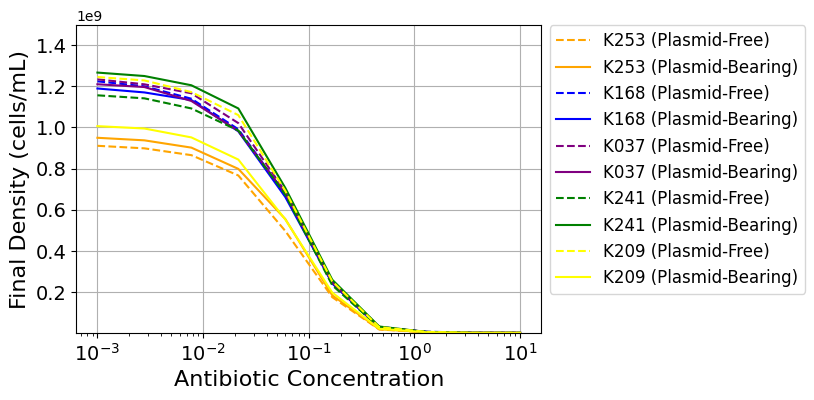

In [9]:

# Run the plotting function
mg.plot_dose_response_curve(dose_response_results, strainIDs, species_colors, outPath=pathFIGURES)


## Run experiments for different transmission matrices

### Removing rows/columns

In [10]:


antibiotic_concentration = 0.2
expe_label='A=%s'%antibiotic_concentration

# Define complete conjuation matrix
plasmid_matrix_complete = np.full((len(strainIDs), len(strainIDs)), eps)
total_removals = len(strainIDs)
num_reps=1

###########
def zero_out_strains(matrix, strainIDs, strains_to_zero):
    """
    Sets the entire row and column of the selected strains to zero.

    Parameters:
    - matrix (numpy array): Original transmission matrix (square).
    - strainIDs (list): List of strain identifiers.
    - strains_to_zero (tuple): Specific strains to set to zero.

    Returns:
    - new_matrix (numpy array): Modified matrix with selected rows/columns zeroed.
    - strainIDs (list): Unchanged strain identifiers.
    """
    new_matrix = matrix.copy()

    # Get indices to zero out
    indices_to_zero = [i for i, strain in enumerate(strainIDs) if strain in strains_to_zero]

    # Zero out selected rows and columns
    new_matrix[indices_to_zero, :] = 0
    new_matrix[:, indices_to_zero] = 0

    return new_matrix, strainIDs  # Return the modified matrix and original strainIDs list

# Generate all possible combinations of removals
num_strains = len(strainIDs)
max_removals = min(num_strains, 5)  # Limit to 5 as per your request

#for num_removals in range(0, max_removals + 1, 1):
for num_removals in []:
    for strains_to_zero in itertools.combinations(strainIDs, num_removals):
        new_matrix, new_strainIDs = zero_out_strains(plasmid_matrix_complete, strainIDs, strains_to_zero)

        print(f"\n=== Matrix with {num_removals} strain removals ({strains_to_zero}) ===")
        df_plasmid = pd.DataFrame(new_matrix, index=new_strainIDs, columns=new_strainIDs)
        print(df_plasmid)

        # Randomly invade with a plasmid
        initial_values_by_strain = {
            "K253": {"0": 1e6, "p": 0},
            "K168": {"0": 1e6, "p": 0},
            "K037": {"0": 1e6, "p": 0},
            "K241": {"0": 1e6, "p": 100},
            "K209": {"0": 1e6, "p": 0},
        }
        #selected_strain = random.choice(list(initial_values_by_strain.keys()))
        #initial_values_by_strain[selected_strain]["p"] = 100
        print("=== Initial densities === ")
        for strain, values in initial_values_by_strain.items():
            print(f"\t{strain}: {values}")

        # Define initial conditions
        populations_0, populations_p = mg.initialize_populations(
            num_species=num_species,
            num_mutationsSNP=num_mutationsSNP,
            num_mutationsIS=num_mutationsIS,
            strainIDs=strainIDs,
            initial_values_by_strain=initial_values_by_strain
        )

        #Run multiple simulations
        results = mg.runManySimulations(
            plasmid_matrix=new_matrix,
            num_reps=num_reps,
            runSimulationIS_multi_species=mg.runSimulationIS_multi_species,
            strains=strains_species,
            initial_populations_0=populations_0,
            initial_populations_p=populations_p,
            num_days=num_days,
            antibiotic_concentration=antibiotic_concentration,
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            dilution_factor=dilution_factor
        )

        #Compute statistics
        diversity_metrics = mg.computeStrainDiversity(results)
        stats = mg.computeMutationAndISTranspositionStatistics(results, num_mutationsSNP, num_mutationsIS, num_species)
        cumulative_densities_free, cumulative_densities_bearing = mg.computeCumulativeStrainDensities(results, num_species, num_days)
        plasmid_fraction_stats = mg.computePlasmidFraction(results)


        #Prints statistics
        mg.printCumulativeStrainDensities(cumulative_densities_free, cumulative_densities_bearing, num_species, strainIDs)
        mg.printPlasmidFraction(plasmid_fraction_stats)
        mg.printStrainDiversity(diversity_metrics)
        mg.printMutationAndISTranspositionStatistics(stats)

        expe_path='' #If empty, dont save figures
        mg.plotResults(new_matrix, populations_0, populations_p, results, num_mutationsSNP, num_mutationsIS, num_days, num_species, species_colors, strainIDs, pathFIGURES, expe_path, antibiotic_concentration)


        #Save results and statistics
        mg.save_simulation_results(new_matrix, num_reps, initial_values_by_strain, num_mutationsSNP, num_mutationsIS, strainIDs, results, diversity_metrics, stats, cumulative_densities_free, cumulative_densities_bearing, plasmid_fraction_stats, save_path=pathSIM)

        print("\n" + "=" * 45 + "\n")




## Stochastic networks


In [11]:

def randomly_remove_transmission(plasmid_matrix, num_removals):
    """
    Iteratively removes (sets to zero) random values from the plasmid transmission matrix.

    Parameters:
    plasmid_matrix (np.array): The initial plasmid transmission matrix.
    num_removals (int): The number of values to remove.

    Returns:
    np.array: Updated plasmid transmission matrix after removals.
    """
    updated_matrix = plasmid_matrix.copy()  # Copy to avoid modifying the original matrix
    rows, cols = updated_matrix.shape

    # Get all indices where transmission is allowed
    allowed_indices = np.argwhere(updated_matrix > 0)

    # Ensure we do not remove more than available connections
    num_removals = min(num_removals, len(allowed_indices))

    # Shuffle and remove connections
    np.random.shuffle(allowed_indices)
    for i in range(num_removals):
        row, col = allowed_indices[i]
        updated_matrix[row, col] = 0  # Set transmission to zero

    return updated_matrix


In [12]:

antibiotic_concentration = 0.2
expe_label='A=%s'%antibiotic_concentration

# Define complete conjuation matrix
plasmid_matrix_complete = np.full((len(strainIDs), len(strainIDs)), eps)
total_removals = len(strainIDs) * len(strainIDs)
num_reps=3

num_expe = 0 #1000  # Number of experiments
for _ in range(num_expe):
    num_removals = np.random.randint(0, total_removals + 1)  # Random number from 0 to total_removals

    new_matrix = randomly_remove_transmission(plasmid_matrix_complete, num_removals)
    print(f"\n=== Matrix with {num_removals} removals ===")
    df_plasmid = pd.DataFrame(new_matrix, index=strainIDs, columns=strainIDs)
    print(df_plasmid)

    # Randomly invade with a plasmid
    initial_values_by_strain = {
        "K253": {"0": 1e6, "p": 0},
        "K168": {"0": 1e6, "p": 0},
        "K037": {"0": 1e6, "p": 0},
        "K241": {"0": 1e6, "p": 0},
        "K209": {"0": 1e6, "p": 0},
    }
    selected_strain = random.choice(list(initial_values_by_strain.keys()))
    initial_values_by_strain[selected_strain]["p"] = 100
    print("=== Initial densities === ")
    for strain, values in initial_values_by_strain.items():
        print(f"\t{strain}: {values}")

    # Define initial conditions
    populations_0, populations_p = mg.initialize_populations(
        num_species=num_species,
        num_mutationsSNP=num_mutationsSNP,
        num_mutationsIS=num_mutationsIS,
        strainIDs=strainIDs,
        initial_values_by_strain=initial_values_by_strain
    )

    #Run multiple simulations
    results = mg.runManySimulations(
        plasmid_matrix=new_matrix,
        num_reps=num_reps,
        runSimulationIS_multi_species=mg.runSimulationIS_multi_species,
        strains=strains_species,
        initial_populations_0=populations_0,
        initial_populations_p=populations_p,
        num_days=num_days,
        antibiotic_concentration=antibiotic_concentration,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        dilution_factor=dilution_factor
    )

    #Compute statistics
    diversity_metrics = mg.computeStrainDiversity(results)
    stats = mg.computeMutationAndISTranspositionStatistics(results, num_mutationsSNP, num_mutationsIS, num_species)
    cumulative_densities_free, cumulative_densities_bearing = mg.computeCumulativeStrainDensities(results, num_species, num_days)
    plasmid_fraction_stats = mg.computePlasmidFraction(results)


    #Prints statistics
    mg.printCumulativeStrainDensities(cumulative_densities_free, cumulative_densities_bearing, num_species, strainIDs)
    mg.printPlasmidFraction(plasmid_fraction_stats)
    mg.printStrainDiversity(diversity_metrics)
    mg.printMutationAndISTranspositionStatistics(stats)

    #Save results and statistics


    mg.save_simulation_results(new_matrix, num_reps, initial_values_by_strain, num_mutationsSNP, num_mutationsIS, strainIDs, results, diversity_metrics, stats, cumulative_densities_free, cumulative_densities_bearing, plasmid_fraction_stats, save_path=pathSIM)

    print("\n" + "=" * 45 + "\n")




# Load and plot simulation results

In [13]:


plasmid_fractions = []
num_zeros_in_matrix = []
SNP_Frequencies = []
IS_Frequencies = []
total_mutants=[]
total_populations=[]

network_densities=[]
network_degrees=[]
network_component_sizes=[]
network_path_lengths=[]
network_clustering_coefficients=[]

# Retrieve all .pkl files in pathSIM
pkl_files = glob.glob(os.path.join(pathSIM, "*.pkl"))

# Iterate through the files and print their names
for file_path in pkl_files:

    # Access data
    loaded_data = mg.load_simulation_results(file_path)



    # Reconstruct the original variables
    plasmid_matrix = loaded_data["plasmid_matrix"]
    network_metrics = mg.compute_network_measures(plasmid_matrix)
    num_zeros = np.sum(plasmid_matrix == 0)
    num_zeros_in_matrix.append(num_zeros)
    print("density=",network_metrics["Density"])
    network_densities.append(network_metrics["Density"])
    network_degrees.append(network_metrics["Mean Degree"])
    network_component_sizes.append(network_metrics["Giant Component Size"])
    network_path_lengths.append(network_metrics["Avg Path Length"])
    network_clustering_coefficients.append(network_metrics["Clustering Coefficient"])

    results = loaded_data["results"]
    num_mutationsSNP = loaded_data["num_mutationsSNP"]
    num_mutationsIS = loaded_data["num_mutationsIS"]
    strainIDs = loaded_data["strainIDs"]
    cumulative_densities_free = loaded_data["cumulative_densities_free"]
    cumulative_densities_bearing = loaded_data["cumulative_densities_bearing"]
    plasmid_fraction_stats = loaded_data["plasmid_fraction_stats"]
    diversity_metrics = loaded_data["diversity_metrics"]

    stats = loaded_data["mutation_statistics"]

    # Retrieve total population of non-mutant cells (SNP Level 0 + IS Level 0)
    total_mutant_cells = stats["Total_Mutant_Cells"]
    total_cells=stats['Total_Population']
    total_mutants.append(total_mutant_cells)
    total_populations.append(total_cells)

    num_species = loaded_data["num_species"] if "num_species" in loaded_data else len(loaded_data["strainIDs"])

    plasmid_fraction = plasmid_fraction_stats["Plasmid Fraction"]
    plasmid_fractions.append(plasmid_fraction)


    SNP_Frequencies.append(stats['SNP_Cumulative_Frequency'])
    IS_Frequencies.append(stats['IS_Cumulative_Frequency'])

    #expe_path='' #If empty, dont save figures
    if False:
    #if loaded_data['initial_values_by_strain']['K241']['p']>0:
        expe_path = os.path.join(pathFIGURES, mg.matrix_to_binary_filename(plasmid_matrix))
        print(expe_path)
        #mg.plotResults(plasmid_matrix, populations_0, populations_p, results, num_mutationsSNP, num_mutationsIS, num_days, num_species, species_colors, strainIDs, pathFIGURES, expe_path, antibiotic_concentration)

        mg.plot_HGT_network(plasmid_matrix, strainIDs, species_colors, outPath=expe_path, node_alpha=0.45)


        frequencies_free, frequencies_bearing = mg.calculateFrequenciesPerStrain(
          results=results,
          num_days=num_days,
          num_species=num_species,
          initial_populations_0=populations_0,
          initial_populations_p=populations_p
        )

        # 5. Plot stacked area chart of strain frequencies
        mg.plotStrainFrequenciesStackedArea(
          frequencies_free, frequencies_bearing, num_days, num_species, species_colors, strainIDs, 'Density=%s'%network_metrics["Density"], expe_path
        )


Simulation results loaded from: /content/drive/MyDrive/SYNC_Projects/IS/runs_eps1e-09/sim_0001000000011000100001100.pkl
density= 0.3
Simulation results loaded from: /content/drive/MyDrive/SYNC_Projects/IS/runs_eps1e-09/sim_0100010001000000000000000.pkl
density= 0.15
Simulation results loaded from: /content/drive/MyDrive/SYNC_Projects/IS/runs_eps1e-09/sim_0110010011010110101000100.pkl
density= 0.55
Simulation results loaded from: /content/drive/MyDrive/SYNC_Projects/IS/runs_eps1e-09/sim_0000110100100100101011110.pkl
density= 0.55
Simulation results loaded from: /content/drive/MyDrive/SYNC_Projects/IS/runs_eps1e-09/sim_1001000100101000000000000.pkl
density= 0.25
Simulation results loaded from: /content/drive/MyDrive/SYNC_Projects/IS/runs_eps1e-09/sim_0110101010001001001010010.pkl
density= 0.5
Simulation results loaded from: /content/drive/MyDrive/SYNC_Projects/IS/runs_eps1e-09/sim_1010011011110110011101001.pkl
density= 0.75
Simulation results loaded from: /content/drive/MyDrive/SYNC_Proj

In [14]:
#print(total_mutants)
dominant_strains = np.argmax(total_mutants, axis=1)  # Get index of the strain with the highest mutation density

# Get indexes where dominant_strains == N
for N in range(num_species):
  indexesN = np.where(dominant_strains == N)[0]  # [0] extracts the array of indexes
  print(strainIDs[N],": ",
        len(indexesN),"/",len(total_mutants), "=",int(1000*len(indexesN)/len(total_mutants))/10,"%")



K253 :  64 / 1028 = 6.2 %
K168 :  406 / 1028 = 39.4 %
K037 :  4 / 1028 = 0.3 %
K241 :  13 / 1028 = 1.2 %
K209 :  541 / 1028 = 52.6 %


Exporting /content/drive/MyDrive/SYNC_Projects/IS/figures/plasmid_fraction_vs_network_density.pdf


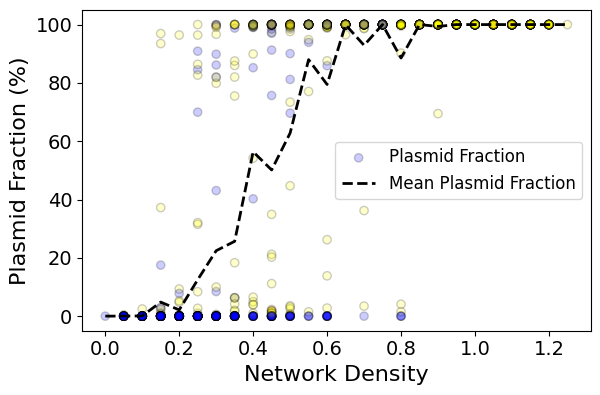

In [15]:


def plotPlasmidFractionVsX(x_values, plasmid_fractions, dominant_strains, species_colors, x_label="X-Axis", outPath=''):
    """
    Plots plasmid fraction against a specified network metric, coloring each point by the dominant strain.
    Includes scatter points with jittering and a dotted trend line showing the mean plasmid fraction.

    Parameters:
    x_values (list): List of x-axis values (e.g., number of 0s, density, mean degree, etc.).
    plasmid_fractions (list): List of plasmid fractions for each simulation.
    dominant_strains (list): List of dominant strain indices per case.
    species_colors (list): List of colors corresponding to each strain.
    x_label (str): Label for the x-axis.
    outPath (str): Path to save the plot (optional).

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=(6, 4))

    # Add small jitter to x_values to prevent overlapping points
    jitter_strength = 0.0 * (max(x_values) - min(x_values))  # Adjust based on x-axis range
    jittered_x = x_values + np.random.uniform(-jitter_strength, jitter_strength, len(x_values))

    # Assign colors based on the dominant strain
    colors = [species_colors[dominant] for dominant in dominant_strains]

    # Scatter plot for plasmid fractions with jittered x-values

    ax.scatter(jittered_x, 100*np.array(plasmid_fractions) , color=colors, edgecolor='black', alpha=0.2, label="Plasmid Fraction")

    # Compute mean plasmid fraction for each unique x_value
    unique_x = np.unique(x_values)
    mean_plasmid_fractions = [
        100*np.mean([plasmid_fractions[i] for i in range(len(x_values)) if x_values[i] == x])
        for x in unique_x
    ]

    # Plot mean plasmid fraction trend line
    ax.plot(unique_x, mean_plasmid_fractions, 'k--', linewidth=2, label='Mean Plasmid Fraction')

    # Labels and title
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel("Plasmid Fraction (%)", fontsize=16)

    # Grid for better visualization
    ax.grid(False)

    # Add legend
    ax.legend(fontsize=12)

    # Adjust layout
    plt.tight_layout()

    ax.tick_params(axis='both', labelsize=14)

    # Save or show the plot
    if outPath:
        filename = f"{outPath}plasmid_fraction_vs_{x_label.replace(' ', '_').lower()}.pdf"
       # plt.savefig(filename, format='png', dpi=300)
        plt.savefig(filename, format='pdf')
        print(f"Exporting {filename}")
        #plt.close()
    plt.show()

# Determine the dominant strain for each case
dominant_strains = np.argmax(total_mutants, axis=1)  # Get index of the strain with the highest mutation density

plotPlasmidFractionVsX(network_densities, plasmid_fractions, dominant_strains, species_colors,x_label="Network Density",outPath=pathFIGURES)





[0.         0.09615385 0.19230769 0.28846154 0.38461538 0.48076923
 0.57692308 0.67307692 0.76923077 0.86538462 0.96153846 1.05769231
 1.15384615 1.25      ]
Exporting /content/drive/MyDrive/SYNC_Projects/IS/figures/mutation_fraction_vs_network_density_boxplot.pdf


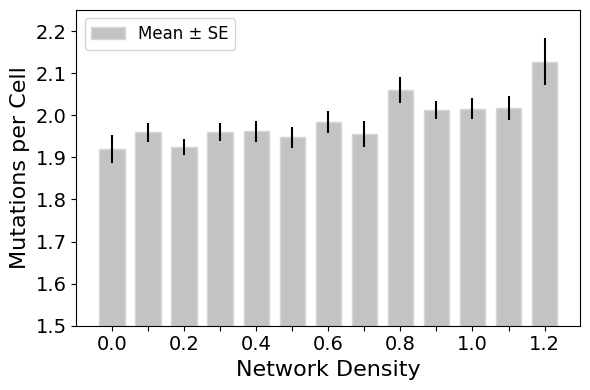

In [16]:

def plotMutantsVsX_boxplot(x_values, total_mutants_per_case, total_population, x_label="X-Axis", outPath=''):
    """
    Plots the total mutations per cell (total_mutants / total_population) against a specified network metric,
    using boxplots with a binned x-axis and overlaying a trend line for the mean with standard error bars.

    Parameters:
    x_values (list or np.array): List of x-axis values (e.g., number of 0s, density, mean degree, etc.).
    total_mutants_per_case (np.array): 2D array (cases × species) with total mutant cells per strain and case.
    total_population (list or np.array): List of total population per case.
    x_label (str): Label for the x-axis.
    outPath (str): Path to save the plot (optional).

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=(6, 4))

    # Convert inputs to arrays
    total_mutants = np.sum(total_mutants_per_case, axis=1)  # Sum over species/strains
    total_population = np.array(total_population)  # Ensure array format

    # Avoid division by zero
    mutation_fraction = np.divide(total_mutants, total_population, out=np.zeros_like(total_mutants), where=total_population != 0)

    # Ensure no negative values in mutation_fraction (clip at zero)
    mutation_fraction = np.clip(mutation_fraction, 0, None)

    # Bin the x-values into 20 bins
    xticks_values = np.arange(0., 1.3, 0.1)  # Explicitly set x-tick values
    num_bins = len(xticks_values)  # Ensure bins match desired xticks

    bins = np.linspace(min(x_values), max(x_values), num_bins + 1)
    bin_indices = np.digitize(x_values, bins) - 1  # Get bin indices (0-based indexing)
    print(bins)
    # Create a dictionary to store mutation fractions per bin
    binned_data = {i: [] for i in range(num_bins)}

    for i, bin_idx in enumerate(bin_indices):
        if bin_idx < num_bins:  # Ignore out-of-bounds indices
            binned_data[bin_idx].append(mutation_fraction[i])

    # Convert binned data to a list (excluding empty bins)
    boxplot_data = [binned_data[i] for i in range(num_bins) if len(binned_data[i]) > 0]

    # Compute bin centers for labeling
    bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(num_bins) if len(binned_data[i]) > 0]

    # Compute mean and standard error for each bin
    mean_mutation_fraction = [np.mean(binned_data[i]) for i in range(num_bins) if len(binned_data[i]) > 0]
    std_error = [np.std(binned_data[i]) / np.sqrt(len(binned_data[i])) if len(binned_data[i]) > 1 else 0 for i in range(num_bins) if len(binned_data[i]) > 0]

    # Bar plot with error bars
    ax.bar(
        range(len(bin_centers)),
        mean_mutation_fraction,
        yerr=std_error,
        capsize=0,
        color='#C3C3C3',   # Light gray for bars
        edgecolor='#D6D6D6',
        width=0.7,
        label='Mean ± SE'
    )

    # Set x-axis labels and ticks
    ax.set_xticks(range(len(bin_centers)))
    ax.set_xticklabels([f"{b:.1f}" if i % 2 == 0 else "" for i, b in enumerate(xticks_values)], fontsize=14)
    ax.set_ylim([1.5, 2.25])
    plt.yticks(fontsize=14)

    # Labels and title
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel("Mutations per Cell", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend(fontsize=12, loc='upper left')

    # Grid for better visualization
    ax.grid(False)

    # Add legend
    ax.tick_params(axis='both', labelsize=14)

    # Adjust layout
    plt.tight_layout()

    # Save or show the plot
    if outPath:
        filename = f"{outPath}mutation_fraction_vs_{x_label.replace(' ', '_').lower()}_boxplot.pdf"
        plt.savefig(filename, format='pdf', dpi=300)
        print(f"Exporting {filename}")
        plt.show()
    else:
        plt.show()

plotMutantsVsX_boxplot(network_densities, total_mutants, total_cells, x_label="Network Density", outPath=pathFIGURES)


Exporting /content/drive/MyDrive/SYNC_Projects/IS/figures/mutation_frequencies_vs_network_density.pdf


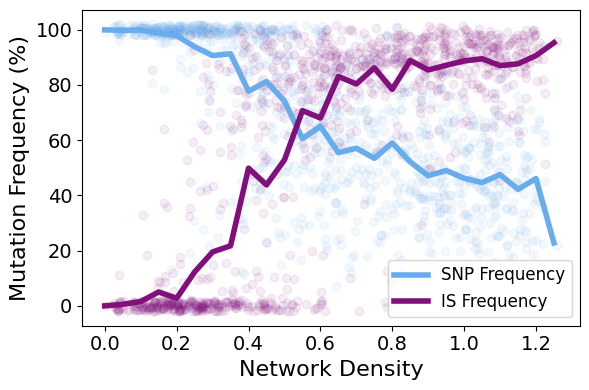

In [17]:


def plotMutationFrequenciesVsX(x_values, SNP_frequencies, IS_frequencies, x_label="X-Axis", outPath=''):
    """
    Plots SNP and IS frequencies as a function of a specified network metric,
    with scatter points (with jittering) and a dotted line for the mean at each unique x_value.

    Parameters:
    x_values (list): List of x-axis values (e.g., number of 0s, density, mean degree, etc.).
    SNP_frequencies (list): List of SNP frequencies for each simulation.
    IS_frequencies (list): List of IS transposition frequencies for each simulation.
    x_label (str): Label for the x-axis.
    outPath (str): Path to save the plot (optional).

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=(6, 4))

    # Define jitter strengths for x-values and frequencies
    jitter_strength_x = 0.02 * (max(x_values) - min(x_values))  # Small jitter for x-axis
    jitter_strength_y = 0.02 * (max(SNP_frequencies + IS_frequencies) - min(SNP_frequencies + IS_frequencies))  # Y-axis jitter

    # Add jitter to x-values
    jittered_x = x_values + np.random.uniform(-jitter_strength_x, jitter_strength_x, len(x_values))

    # Add jitter to y-values
    jittered_SNP = SNP_frequencies + np.random.uniform(-jitter_strength_y, jitter_strength_y, len(SNP_frequencies))
    jittered_IS = IS_frequencies + np.random.uniform(-jitter_strength_y, jitter_strength_y, len(IS_frequencies))

    # Scatter plot for SNP frequencies with jitter
    ax.scatter(jittered_x, jittered_SNP, color='#69acecff', alpha=0.075, edgecolor='#69acecff')

    # Scatter plot for IS frequencies with jitter
    ax.scatter(jittered_x, jittered_IS, color='#810F7C', alpha=0.075, edgecolor='#810F7C')

    # Compute mean SNP and IS frequency for each unique x_value
    unique_x = np.unique(x_values)
    mean_SNP = [np.mean([SNP_frequencies[i] for i in range(len(x_values)) if x_values[i] == x]) for x in unique_x]
    mean_IS = [np.mean([IS_frequencies[i] for i in range(len(x_values)) if x_values[i] == x]) for x in unique_x]

    # Plot mean SNP and IS frequencies as dotted lines
    ax.plot(unique_x, mean_SNP, '-', color='#69acecff',linewidth=4, label='SNP Frequency')
    ax.plot(unique_x, mean_IS, '-', color='#810F7C',linewidth=4, label='IS Frequency')

    # Labels and title
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel("Mutation Frequency (%)", fontsize=16)

    # Grid and legend
    ax.grid(False)
    ax.legend(fontsize=12, loc='lower right')
    ax.tick_params(axis='both', labelsize=14)

    # Adjust layout
    plt.tight_layout()

    # Save or show the plot
    if outPath:
        filename = f"{outPath}mutation_frequencies_vs_{x_label.replace(' ', '_').lower()}.pdf"
        plt.savefig(filename, format='pdf', dpi=300)
        print(f"Exporting {filename}")
        plt.show()
    else:
        plt.show()



plotMutationFrequenciesVsX(network_densities, SNP_Frequencies, IS_Frequencies, x_label="Network Density", outPath=pathFIGURES)
